In [27]:
import numpy as np
import math
class CosineRestartLRCallback():
    """
    Cosine annealing learning rate scheduling with restart.
    Also, the top of the LR after each resrt will respect the same cosine annealing config, but relative to the whole number of training steps.
    Can be looked at as 2 threads:
    - 1 to cosine aneal the maximum LR
    - 1 to cosine aneal the lr per each restart
    Overall, minimum is kept at initial_lr*cosine_final_lr_ratio, while maximum cosinely decreases.
    Between restarts, the LR moves from maximum of current batch, to the minimum LR
    """

    def __init__(self, max_epochs, cosine_top_final_lr_ratio, cosine_final_lr_ratio, cosine_restart_epochs, **kwargs):
        self.max_epochs = max_epochs
        self.cosine_top_final_lr_ratio = cosine_top_final_lr_ratio
        self.cosine_final_lr_ratio = cosine_final_lr_ratio
        self.cosine_restart_epochs = cosine_restart_epochs

        self.lr_warmup_epochs = 1
        self.lr_warmup_steps = 1
        self.train_loader_len = 2500
        self.lr_cooldown_epochs = 1
        self.initial_lr = 0.003


    def perform_scheduling(self, epoch, batch_idx):
        curr_epoch = epoch
        curr_batch_idx = batch_idx
        effective_epoch = max(0, curr_epoch - self.lr_warmup_epochs)
        # top LR cosine annealing thread
        restart_start_iter = max(0, ((self.train_loader_len * effective_epoch + curr_batch_idx - self.lr_warmup_steps) // self.cosine_restart_epochs) * self.cosine_restart_epochs)
        whole_max_epochs = self.max_epochs - self.lr_warmup_epochs
        whole_max_iter = self.train_loader_len * whole_max_epochs
        
        # restart LR cosine annealing thread
        epoch_start_as_steps = self.train_loader_len * effective_epoch

        # batch_top_lr is the LR of the first item in restart batch
        batch_bottom_lr = self.compute_learning_rate(epoch_start_as_steps, whole_max_iter, self.initial_lr, self.cosine_top_final_lr_ratio, warmup_perc=0)
        batch_top_lr = self.compute_learning_rate(restart_start_iter, whole_max_iter, self.initial_lr, self.cosine_top_final_lr_ratio, warmup_perc=0)
        
        restart_batch_len = self.train_loader_len * self.cosine_restart_epochs
        max_iter = min(epoch_start_as_steps - self.lr_warmup_steps + restart_batch_len, whole_max_iter)
        # print("epoch_start_as_steps", epoch_start_as_steps, curr_batch_idx)
        current_iter = max(0, (epoch_start_as_steps + curr_batch_idx - self.lr_warmup_steps)) % restart_batch_len
        # print(restart_batch_len, current_iter, max_iter)
        current_restart_max_iter = restart_batch_len if restart_start_iter < (max_iter-(max_iter%restart_batch_len)) else (max_iter%restart_batch_len)

        lr = self.compute_learning_rate(current_iter, current_restart_max_iter, batch_top_lr,
                                        # self.cosine_final_lr_ratio*(self.initial_lr/batch_top_lr),
                                        (batch_bottom_lr/batch_top_lr)*self.cosine_final_lr_ratio,
                                        warmup_perc=.6
                                       )

        # deploy
        self.lr = float(lr)
        # print(lr)
        return self.lr

    def is_lr_scheduling_enabled(self, context):
        # Account of per-step warmup
        if self.lr_warmup_steps > 0:
            current_step = self.train_loader_len * context.epoch + context.batch_idx
            return current_step >= self.lr_warmup_steps

        post_warmup_epochs = self.max_epochs - self.lr_cooldown_epochs
        return self.lr_warmup_epochs <= context.epoch < post_warmup_epochs

    @classmethod
    def compute_learning_rate(cls, step, total_steps: float, initial_lr: float, bottom_lr_ratio: float, warmup_perc=0.4):
        # the cosine starts from initial_lr and reaches initial_lr * cosine_final_lr_ratio in last epoch
        warmup = (warmup_perc*total_steps)
        step = 0 if step < warmup else ((step-warmup)/(total_steps-warmup))*total_steps
        lr = 0.5 * initial_lr * (1.0 + np.cos(step / (total_steps + 1) * math.pi))
        return lr * (1 - bottom_lr_ratio) + (initial_lr * bottom_lr_ratio)

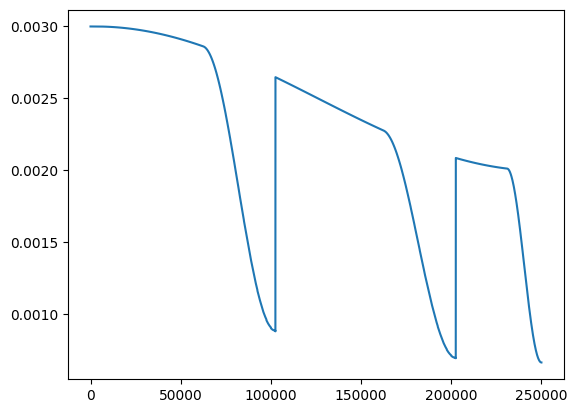

In [28]:
from matplotlib import pyplot as plt

csrlrc = CosineRestartLRCallback(max_epochs=100, cosine_top_final_lr_ratio=0.666, cosine_final_lr_ratio=0.333, cosine_restart_epochs=40)
csrlrc.lr_warmup_epochs = 1
csrlrc.lr_warmup_steps = 1
csrlrc.train_loader_len = 2500
csrlrc.lr_cooldown_epochs = 1
csrlrc.initial_lr = 0.003

a = []
for e in range(100):
    for b in range(2500):
        a.append(csrlrc.perform_scheduling(e,b))
plt.plot(a)